# GDP and life expectancy

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2013 and the life expectancy of people born in that country in 2013.

## Getting the data

Two datasets of the World Bank are considered. One dataset, available at <http://data.worldbank.org/indicator/NY.GDP.MKTP.CD>, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows us to compare GDP values across countries. The other dataset, available at <http://data.worldbank.org/indicator/SP.DYN.LE00.IN>, lists the life expectancy of the world's countries. The datasets were downloaded as CSV files in March 2016.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

YEAR = 2013
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdpReset = pd.read_csv('WB GDP 2013.csv')

LIFE_INDICATOR = 'SP.POP.TOTL'
popReset = pd.read_csv('WB POP 2013.csv')
popReset.head()

,country,year,SP.POP.TOTL
0,Arab World,2013,3.770967e+08
1,Caribbean small states,2013,6.975819e+06
2,Central Europe and the Baltics,2013,1.037137e+08
3,East Asia & Pacific (all income levels),2013,2.248867e+09
4,East Asia & Pacific (developing only),2013,2.006073e+09


## Cleaning the data

Inspecting the data with `head()` and `tail()` shows that:

1. the first 34 rows are aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
- GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:
1. removing the first 34 rows;
- removing rows with unavailable values.

In [2]:
gdpCountries = gdpReset[34:].dropna()
popCountries = popReset[34:].dropna()


## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2013 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [3]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.564768

GDP = 'GDP (£m)'
gdpCountries[GDP] = gdpCountries[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)
gdpCountries.head()

,country,year,NY.GDP.MKTP.CD,GDP (£m)
34,Afghanistan,2013,2.045894e+10,13075
35,Albania,2013,1.278103e+10,8168
36,Algeria,2013,2.097035e+11,134016
38,Andorra,2013,3.249101e+09,2076
39,Angola,2013,1.383568e+11,88420


The unnecessary columns can be dropped.

In [4]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdpClean = gdpCountries[headings]
gdpClean.head()

,country,GDP (£m)
34,Afghanistan,13075
35,Albania,8168
36,Algeria,134016
38,Andorra,2076
39,Angola,88420


The World Bank reports the population in thousands. After rounding, the original column is discarded.

In [5]:
POP= 'Population (total)'
popCountries[POP] = popCountries[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, POP]
lifeClean = popCountries[headings]
lifeClean.head()

,country,Population (total)
34,Afghanistan,30682500
35,Albania,2897366
36,Algeria,38186135
37,American Samoa,55302
38,Andorra,75902


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [6]:
gdpVspop = pd.merge(gdpClean, lifeClean, on=COUNTRY, how='inner')
gdpVspop.head()

,country,GDP (£m),Population (total)
0,Afghanistan,13075,30682500
1,Albania,8168,2897366
2,Algeria,134016,38186135
3,Andorra,2076,75902
4,Angola,88420,23448202


## Calculating the correlation

To measure if the population and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [7]:
from scipy.stats import spearmanr

gdpColumn = gdpVspop[GDP]
popColumn = gdpVspop[POP]
(correlation, pValue) = spearmanr(gdpColumn, popColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.7334471556845619
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer larger number of people living in the country, but it is not very strong.

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

<AxesSubplot:xlabel='GDP (£m)', ylabel='Population (total)'>

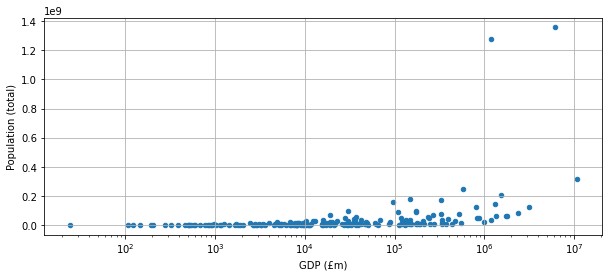

In [8]:
%matplotlib inline
gdpVspop.plot(x=GDP, y=POP, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with lower population rate. and countries with around 10 thousand (10<sup>4</sup>) million pounds GDP have a lower population rate. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>4</sup>), most countries have either a lower or higher population rate, whilst below that threshold most countries' have a lower populaton total. 

Comparing the 10 poorest countries and the 10 countries with the lowest population shows that total GDP is a rather crude measure. The population size should be taken into account for a more precise definiton of what 'poor' and 'rich' means. Furthermore, looking at the countries below, droughts and internal conflicts may also play a role in life expectancy. 
Another observation is that countries with a lower population rate tend to have a lower GDP as this involves a measure of population as against income etc.

In [12]:
# the 10 countries with lowest GDP
gdpVspop.sort_values(GDP).head(10)

,country,GDP (£m),Population (total)
178,Tuvalu,24,9876
89,Kiribati,108,108544
110,Marshall Islands,122,52786
131,Palau,146,20919
145,Sao Tome and Principe,195,182386
114,"Micronesia, Fed. Sts.",202,103718
173,Tonga,277,105139
49,Dominica,324,72005
38,Comoros,383,751697
162,St. Vincent and the Grenadines,461,109327


In [14]:
# the 10 countries with lowest population
gdpVspop.sort_values(POP).head(10)

,country,GDP (£m),Population (total)
178,Tuvalu,24,9876
131,Palau,146,20919
57,Faeroe Islands,1670,48292
110,Marshall Islands,122,52786
160,St. Kitts and Nevis,503,54301
19,Bermuda,3562,65001
49,Dominica,324,72005
3,Andorra,2076,75902
149,Seychelles,902,89900
5,Antigua and Barbuda,767,89985


## Conclusions

To sum up, there seems to be a significant correlation between a country's wealth and its population: there is often a relationship between countries with lower population rate and a lower GDP. Looking Tuvalu, it is obvious the country has a lower GDP because of its few inhabitants.

Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.

## NOW IS YOUR TURN


## GOOD LUCK!